**Check Python Version**

In [0]:
import sys
sys.version

# make sure to enable GPU acceleration!
device = 'cuda'

**Install pytorch and torchvision**

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())


0.4.0
True


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import os
os.listdir('drive/My Drive/Venice-boat')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [0]:
import numpy as np
import time
import copy
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.datasets import make_classification
from collections import OrderedDict
from skimage.io import imread

import matplotlib.pyplot as plt
import matplotlib as mpl

print('PyTorch version:', torch.__version__)

PyTorch version: 0.4.0


**Data Augmentation**

In [0]:
# https://medium.com/@ml_kid/dealing-with-pil-image-has-no-attribute-register-extensions-7d79b4e7dcf0

!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [0]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),     
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
     ]),
    
    'valid' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
}

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])


In [0]:
train_dir = 'train'
valid_dir = 'valid'


dirs = {'train': 'drive/My Drive/Venice-boat/data/venice_traindata', 
        'valid': 'drive/My Drive/Venice-boat/data/classified_venice_testdata'}

image_datasets = {x: torchvision.datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=500, shuffle=True) for x in ['train', 'valid']}
print(len(dataloaders['train']))
print(len(dataloaders['valid']))

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}

train_class_names = image_datasets['train'].classes
valid_class_names = image_datasets['valid'].classes
print(train_class_names)
print(len(train_class_names))
print(len(valid_class_names))

8
3
['Alilaguna', 'Ambulanza', 'Barchino', 'Gondola', 'Lanciafino10m', 'Lanciafino10mBianca', 'Lanciafino10mMarrone', 'Lanciamaggioredi10mBianca', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Topa', 'VaporettoACTV']
18
18


**Data Exploratory**

In [0]:
def plots(ims, figsize=(24,12), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

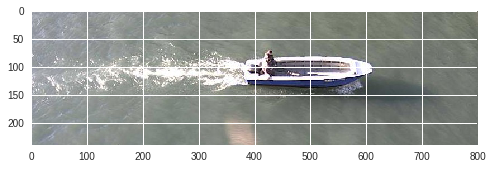

In [0]:
boat_image_path = 'drive/My Drive/Colab Notebooks/Venice-boat/data/venice_traindata/Barchino/20130304_071400_20181.jpg'
image = np.expand_dims(plt.imread(boat_image_path), 0)
plt.imshow(image[0])

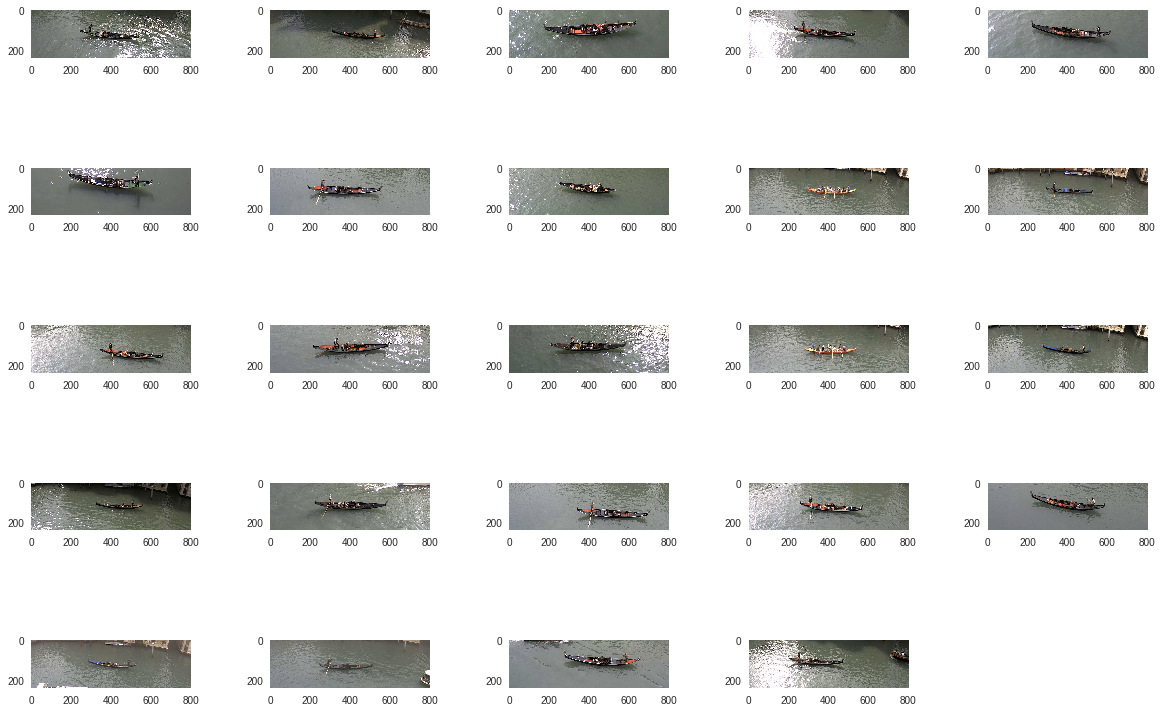

In [0]:
def plot_images():
    folder = "drive/My Drive/Colab Notebooks/Venice-boat/data/venice_traindata/Gondola/"
    images = os.listdir(folder)
    i = 0
    plt.figure(figsize=[20,14]) # set image size
    plt.subplots_adjust(wspace = 0.5)# set distance between the subplots
    for image in images:
        plt.subplot(5,5,i+1)
        im = imread(folder+image)
        i+=1
        imgplot = plt.imshow(im)
    plt.show()
    
plot_images()

In [0]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25):
    model.to(device='cuda') 
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
# Create model, optimizer and loss function
vgg_model = models.vgg16(pretrained=True)
    

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(89600, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 18)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# freeze the pre-trained layers
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier = classifier
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_function = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(vgg_model.classifier.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=10

# train our model
model_ft = train_model(vgg_model, loss_function, optimizer, scheduler, eps)


Epoch 0/9
----------


RuntimeError: ignored